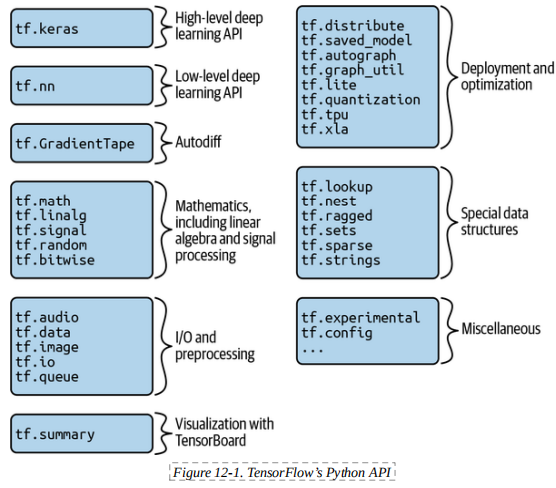

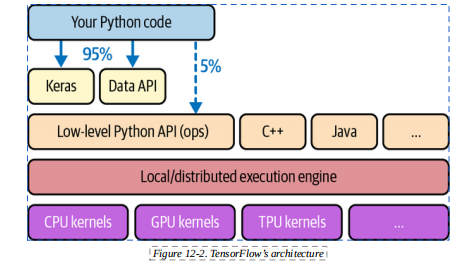

## Tạo Tensor

In [2]:
import tensorflow as tf

t = tf.constant([[1,2,3], [4,5,6]]) #matrix
t

<tf.Tensor: shape=(2, 3), dtype=int32, numpy=
array([[1, 2, 3],
       [4, 5, 6]], dtype=int32)>

In [3]:
t.shape

TensorShape([2, 3])

In [4]:
t.dtype

tf.int32

In [5]:
t + 10

<tf.Tensor: shape=(2, 3), dtype=int32, numpy=
array([[11, 12, 13],
       [14, 15, 16]], dtype=int32)>

## Variables

In [6]:
v = tf.Variable([[1., 2., 3.], [4., 5., 6.]])
v

<tf.Variable 'Variable:0' shape=(2, 3) dtype=float32, numpy=
array([[1., 2., 3.],
       [4., 5., 6.]], dtype=float32)>

In [7]:
v.assign(2 * v)

<tf.Variable 'UnreadVariable' shape=(2, 3) dtype=float32, numpy=
array([[ 2.,  4.,  6.],
       [ 8., 10., 12.]], dtype=float32)>

In [8]:
v[:, 2].assign([0., 1.])

<tf.Variable 'UnreadVariable' shape=(2, 3) dtype=float32, numpy=
array([[ 2.,  4.,  0.],
       [ 8., 10.,  1.]], dtype=float32)>

# Custom Loss Function

Nhắc lại lý thuyết Huber loss

In [ ]:
# Implement Huber Loss
# Tensorflow chỉ truyền vào y_true và y_pred đó
def huber_fn(y_true, y_pred):
    error = y_true - y_pred
    is_small_error = tf.abs(error) < 1
    squared_loss = tf.square(error) / 2
    linear_loss = tf.abs(error) - 0.5
    return tf.where(is_small_error, squared_loss, linear_loss)

In [ ]:
# Insert vào trong lúc Compile
model.compile(loss=huber_fn, optimizer="nadam")
model.fit(X_train, y_train,...)

In [ ]:
# Lúc save Model cũng cần lưu lại
model = tf.keras.models.load_model("my_model_with_a_custom_loss",
                                    custom_object={"huber_fn": huber_fn}
                                   )
# Nếu decorate cho huber_fn bằng @keras.utils.register_keras_serializable()

In [ ]:
def create_huber(threshold=1.0):
    def huber_fn(y_true, y_pred):
        error = y_true - y_pred
        is_small_error = tf.abs(error) < threshold
        squared_loss = tf.square(error) / 2
        linear_loss = threshold*tf.abs(error) - threshold ** 2 / 2
        return tf.where(is_small_error, squared_loss, linear_loss)
    return huber_fn

model.compile(loss=create_huber(2.0), optimizer="nadam")
model = tf.keras.models.load_model(
    "my_model_with_a_custom_loss_threshold_2",
    custom_objects={"huber_fn": create_huber(2.0)}
)        

In [ ]:
class HuberLoss(tf.keras.losses.Loss):
    def __init__(self, threshold=1.0, **kwargs):
        self.threshhold = threshold
        super().__init__(**kwargs)
    
    def call(self, y_true, y_pred):
        error = y_true - y_pred
        is_small_error = tf.square(error) / 2
        squared_loss = tf.square(error) / 2
        linear_loss = self.loss()
    
    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "threshold": self.threshold}

In [ ]:
def my_softplus(z):
    return tf.math.log(1.0 + tf.exp(z))

def my_glorot_initialzizer(shape, dtype=tf.float32):
    std = tf.sqrt(2. / (shape[0] + shape[1]))
    return tf.random.normal(shape, stddev=std, dtype=dtype)

def my_l1_regularizer(weights):
    return tf.reduce_sum(tf.abs(0.01 * weights))

def my_positive_weights(weights):
    return tf.where(weights < 0., tf.zeros_like(weights), weights)

In [ ]:
layer = tf.keras.layers.Dense(1, activation=my_softplus,
                              kernel_initializer=my_glorot_initialzizer,
                              kernel_regularizer=my_l1_regularizer,
                              kernel_constraint=my_positive_weights
                              )

In [13]:
# Custom lại L1 Regularizer
class MyL1Regularizer(tf.keras.regularizers.Regularizer):
    def __init__(self, factor, **kwargs):
        self.factor = factor
        super().__init__(kwargs)
    
    def __call__(self, weights):
        return tf.reduce_sum(tf.abs(self.factor * weights))
    
    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "factor": self.factor}

In [ ]:
# Custom Metrics Custom cũng giống cái Loss, nhưng nó không được mang đi cập nhật cho trọng số
model.compile(loss="mse", optimizer="nadam", metrics=[create_huber(2.0)])

In [ ]:
# Streaming Metrics
class HuberMetrics(tf.keras.metrics.Metric):
    def __init__(self, threshold=1.0, **kwargs):
        super().__init__(**kwargs)
        self.threshhold = threshold
        self.huber_fn = create_huber(threshold)

    def update_state(self, y_true, y_pred, sample_weight=None):
        sample_metrics = self.huber_fn(y_true, y_pred)
        self.total.assign_add(tf.reduce_sum(sample_metrics))
        self.count.assign_add(tf.cast(tf.size(y_true), tf.float32))
    
    def result(self):
        return self.total / self.count
    
    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "threshold": self.threshhold}


# Custom Layer

In [ ]:
class MyDense(tf.keras.layer.Layer):
    def __init__(self, units, activation=None, **kwargs):
        super().__init__(kwargs)
        self.units = units
        self.activation = tf.keras.activations.get(activation)
    
    def build(self, batch_input_shape):
        self.kernel = self.add_weight(
            name="kernel", shape=[batch_input_shape[-1], self.units],
            initializer="glorot_normal"
        )
    
    def call(self, X):
        return self.activation(X @ self.kernel + self.bias)
    
    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "units": self.units,
                    "activation": tf.keras.activations.serialize(self.activation)
                }



In [ ]:
class MyMultiLayer(tf.keras.layers.Layer):
    def call(self, X):
        X1, X2 = X
        return X1 + X2, X1 * X2, X1 / X2

# Custom Models

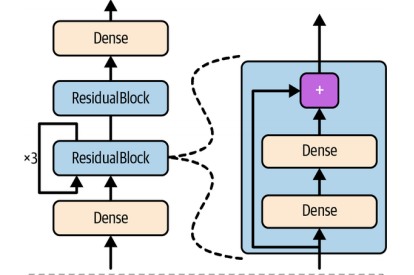

In [15]:
class ResidualBlock(tf.keras.layers.Layer):
    def __init__(self, n_layers, n_neurons, **kwargs):
        super().__init__(kwargs)
        self.hidden = [
            tf.keras.layers.Dense(n_neurons, activation="relu",
                                  kernel_initializer="he_normal")
            for _ in range(n_layers)
        ]

    def call(self, inputs):
        Z = inputs
        for layers in self.hidden:
            Z = layer(Z)
        return inputs + Z

In [16]:
class ResidualRegressor(tf.keras.Model):
    def __init__(self, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.hidden1 = tf.keras.layers.Dense(30, activation="relu",
                                             kernel_initializer="he_normal")
        
        self.block1 = ResidualBlock(2, 30)
        self.block2 = ResidualBlock(2, 30)
        self.out = tf.keras.layers.Dense(output_dim)

    def call(self, inputs):
        Z = self.hidden(inputs)
        for _ in range(1 + 3):
            Z = self.block1(Z)
        Z = self.block2(Z)
        return self.out(Z)
    # Chỗ này cần cài đặt thêm get_config

In [ ]:
class ReconstructingRegressor(tf.keras.Model):
    def __init__(self, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.hidden = [tf.keras.layers.Dense(30, activation="relu",
                                             kernel_initializer="he_nomal")
                                             
                        for _ in range(5)]
        self.out = tf.keras.layers.Dense(output_dim)
        self.reconstruction_mean = tf.keras.metrics.Mean(name="reconstruction_error")

    def build(self, batch_input_shape):
        n_inputs = batch_input_shape[-1]
        self.reconstruct = tf.keras.layers.Dense(n_inputs)

    def call(self, inputs, training=False):
        Z = inputs
        for layer in self.hidden:
            Z = layer(Z)
        reconstruction = self.reconstruct(Z)
        recon_loss = tf.reduce_mean(tf.square(reconstruction - inputs))
        self.add_loss(0.05 * recon_loss) ## Hệ số loss trả về cho mô hình tổng thể
        if training:
            result = self.reconstruct_mean(recon_loss)
            self.add_metric(result) # Cái này là để phục vụ lúc train nó sẽ hiển thị
        return self.out(Z)